### NN Exploration in Pytorch ###
We learn to fit simple classifiers on tabular data using pytorch. We eventually move to fast.ai framework to see how it simplifies this process. A very small dataset called "Titanic" is used here. 
https://www.kaggle.com/competitions/titanic/

In [1]:
import os
from pathlib import Path

In [2]:
path = Path("titanic")
if not path.exists():
    import kaggle,zipfile
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
!ls

README.md  SimpleNNOnTitanic.ipynb  submission.csv  titanic  titanic.zip


In [4]:
import numpy as np, pandas as pd
import torch

In [5]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140,sci_mode=False,edgeitems=5)
pd.set_option('display.width',140)

In [6]:
df = pd.read_csv(path/"train.csv")

In [7]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [8]:
df.isna().sum()
## missing data => 177 out of 891 people have missing age, 687 has missing cabin etc.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Model Idea: We start with a simple model. Numericalized input matrix x Some weights => predictions. Each row in this "input matrix" represents data corresponding to a passenger. Prediction is 0/1 depending on whether they survived. To do this, we need to handle missing data. Easy way is to replace each missing column value with its mode

In [9]:
df.mode().iloc[0] ## take the top row of "mode" to break ties

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [10]:
modes = df.mode().iloc[0]

In [11]:
## replace missing values with modes in-place
df.fillna(modes,inplace=True)

In [12]:
df.isna().sum() ## no more missing values

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [13]:
df.describe(include=object) ## catagorical data

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
df.describe(include=np.number) 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

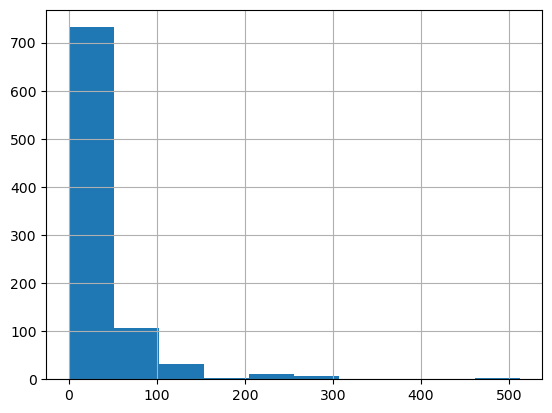

In [15]:
df.Fare.hist()

In [16]:
## correct long-tail distribution by taking log
df['Log-Fare']=np.log(df.Fare + 1.0)

<Axes: >

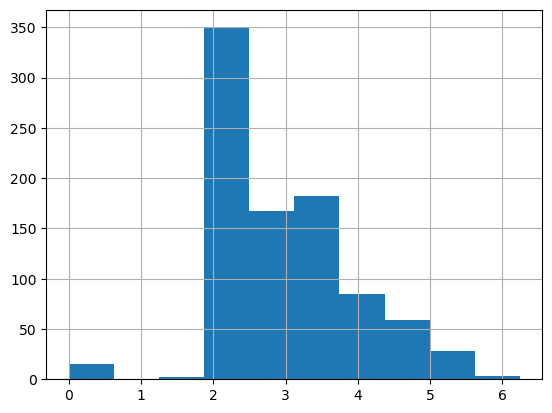

In [17]:
df['Log-Fare'].hist() ## this one is more 

In [18]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [19]:
df.Pclass.unique() 
## this one also looks like 3 unique levels representing firstclass, 2ndclass, 3rd class => require encoding

array([3, 1, 2])

In [20]:
## overall, we need to encode columns "Sex", "Embarked", and "Pclass". 
## Remaining catagorical ones can be ignored as they have too many unique values

In [21]:
## dummy variables can be easily created using pandas to represent these using one-hot-encoding. One column for each unique value of the column
df = pd.get_dummies(df,columns=["Sex", "Embarked","Pclass"])

In [22]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Log-Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [23]:
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Log-Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,False,True,False,False,True,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,4.280593,True,False,True,False,False,True,False,False
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,True,False,False,False,True,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,True,False,False,False,True,True,False,False
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,False,True,False,False,True,False,False,True


In [24]:
new_cols = ['Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']

In [25]:
df[new_cols].head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,False,True,False,False,True,False,False,True
1,True,False,True,False,False,True,False,False
2,True,False,False,False,True,False,False,True
3,True,False,False,False,True,True,False,False
4,False,True,False,False,True,False,False,True


In [26]:
## create dependent and independent variable
from torch import tensor

In [27]:
t_dep = tensor(df.Survived.astype(float))

In [28]:
indep_columns = ['Age', 'SibSp', 'Parch', 'Log-Fare'] + new_cols

In [29]:
df[indep_columns].head()

,Age,SibSp,Parch,Log-Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,2.110213,False,True,False,False,True,False,False,True
1,38.0,1,0,4.280593,True,False,True,False,False,True,False,False
2,26.0,0,0,2.188856,True,False,False,False,True,False,False,True
3,35.0,1,0,3.990834,True,False,False,False,True,True,False,False
4,35.0,0,0,2.202765,False,True,False,False,True,False,False,True


In [30]:
df[indep_columns].astype(float).describe()

,Age,SibSp,Parch,Log-Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,28.566970,0.523008,0.381594,2.962246,0.352413,0.647587,0.188552,0.086420,0.725028,0.242424,0.206510,0.551066
std,13.199572,1.102743,0.806057,0.969048,0.477990,0.477990,0.391372,0.281141,0.446751,0.428790,0.405028,0.497665
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,2.187218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,0.000000,0.000000,2.737881,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,35.000000,1.000000,0.000000,3.465736,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,80.000000,8.000000,6.000000,6.240917,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
t_indep = tensor(df[indep_columns].astype(float).values,dtype=torch.float)

In [32]:
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  ...,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  ...,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  ...,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  ...,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  ...,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [27.0000,  0.0000,  0.0000,  2.6391,  0.0000,  ...,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [19.0000,  0.0000,  0.0000,  3.4340,  1.0000,  ...,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [24.0000,  1.0000,  2.0000,  3.1966,  1.0000,  ...,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [26.0000,  0.0000,  0.0000,  3.4340,  0.0000,  ...,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [32.0000,  0.0000,  0.000

In [33]:
t_indep.shape, t_dep.shape

(torch.Size([891, 12]), torch.Size([891]))

In [34]:
## data is ready=> now fit a basic model ##
# independent variables represented as X, dependent variable represented as y
# model is F(X) = y; learn the function F from the training examples
torch.manual_seed(442)
n_coeff = t_indep.shape[1] ## no. of parameters needed
coeff = torch.rand(n_coeff) - 0.5 ## random initialization centered around zero

In [35]:
preds = t_indep*coeff

In [36]:
preds

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  ...,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  ...,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  ...,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  ...,   0.0000,   0.2799,  -0.4392,   0.0000,   0.0000],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  ...,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        ...,
        [-12.4983,   0.0000,   0.0000,  -0.5968,  -0.0000,  ...,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [ -8.7951,   0.0000,   0.0000,  -0.7766,  -0.2632,  ...,   0.0000,   0.2799,  -0.4392,   0.0000,   0.0000],
        [-11.1096,   0.1386,   0.4818,  -0.7229,  -0.2632,  ...,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-12.0354,   0.0000,   0.0000,  -0.7766,  -0.0000, 

In [37]:
## age column is in a different range so we need normalization
denom_vals, indices = t_indep.max(dim=0)

In [38]:
denom_vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [39]:
t_indep = t_indep/denom_vals

In [40]:
t_indep ##values are now in range

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 0.0000,  ..., 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 1.0000,  ..., 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 1.0000,  ..., 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 1.0000,  ..., 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 0.0000,  ..., 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3375, 0.0000, 0.0000, 0.4229, 0.0000,  ..., 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.2375, 0.0000, 0.0000, 0.5502, 1.0000,  ..., 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [0.3000, 0.1250, 0.3333, 0.5122, 1.0000,  ..., 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3250, 0.0000, 0.0000, 0.5502, 0.0000,  ..., 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.0000, 0.3476, 0.0000,  ..., 1.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

In [41]:
preds = t_indep*coeff

In [42]:
preds

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000,  ...,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632,  ...,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632,  ...,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632,  ...,  0.0000,  0.2799, -0.4392,  0.0000,  0.0000],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000,  ...,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1562,  0.0000,  0.0000, -0.0956, -0.0000,  ...,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.1099,  0.0000,  0.0000, -0.1244, -0.2632,  ...,  0.0000,  0.2799, -0.4392,  0.0000,  0.0000],
        [-0.1389,  0.0173,  0.0803, -0.1158, -0.2632,  ...,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1504,  0.0000,  0.0000, -0.1244, -0.0000,  ...,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1852,  0.0000,  0.000

In [43]:
## reduce predictions to a single number
preds = (t_indep*coeff).sum(axis=1)

In [44]:
preds.shape

torch.Size([891])

In [45]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494, -0.7523,  0.0453,  0.1411, -0.9302,  0.2961,  0.2128,  0.2464])

to improve these predictions based on intial random guesses of model parameters, we need to improve these params
We use gradient descend to do this. But,a loss funtion is needed for gradient calculation. MAE is a good one to start with

In [46]:
loss = torch.abs(preds-t_dep).mean()

In [47]:
loss

tensor(0.6020, dtype=torch.float64)

In [48]:
## create functions to make predictions and calculate loss
def calc_preds(coeffs,indeps):
    return (indeps*coeffs).sum(axis=1)
    
def calc_loss(coeffs,indeps,deps):
    preds = calc_preds(coeffs,indeps)
    return torch.abs(preds-deps).mean()

In [49]:
calc_loss(coeff,t_indep,t_dep)

tensor(0.6020, dtype=torch.float64)

In [50]:
## say that coeff needs gradients
coeff.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [51]:
loss = calc_loss(coeff,t_indep,t_dep)

In [52]:
loss

tensor(0.6020, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [53]:
loss.backward()

In [54]:
## check the gradients
coeff.grad

tensor([-0.1019,  0.0070, -0.0082, -0.1458, -0.1886,  0.0191, -0.0786,  0.0101, -0.1010, -0.2424, -0.1706,  0.2435])

In [55]:
## gradients get accumulated. So if we run this again, grad should double

In [56]:
loss = calc_loss(coeff,t_indep,t_dep)

In [57]:
loss

tensor(0.6020, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [58]:
loss.backward()

In [59]:
## check the gradients
coeff.grad

tensor([-0.2037,  0.0140, -0.0165, -0.2916, -0.3771,  0.0382, -0.1571,  0.0202, -0.2020, -0.4848, -0.3412,  0.4871])

In [60]:
loss = calc_loss(coeff,t_indep,t_dep) ## find loss
loss.backward() ## do backward to get gradient
print(f'current loss={loss}')
with torch.no_grad():
    coeff.sub_(coeff.grad*0.1) ## update by moving a little in the opp. directon of gradient
    coeff.grad.zero_()
    print(f'new loss={calc_loss(coeff,t_indep,t_dep)}')

current loss=0.6020415945252452
new loss=0.5377140172269074


In [61]:
## now that we have basic idea, split full data into training and testing ##
from fastai.data.transforms import RandomSplitter

In [62]:
train_split,val_split = RandomSplitter(seed=42)(df)

In [63]:
train_split,val_split ## divide instance indices

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [64]:
## split data with these indices
train_x,train_y = t_indep[train_split],t_dep[train_split]
valid_x,valid_y = t_indep[val_split],t_dep[val_split]

In [65]:
train_x.shape,train_y.shape,valid_x.shape,valid_y.shape

(torch.Size([713, 12]),
 torch.Size([713]),
 torch.Size([178, 12]),
 torch.Size([178]))

In [66]:
## now package everything into functions
def init_coeffs(n_coeff):
    return (torch.rand(n_coeff)-0.5).requires_grad_()

def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

## do one epoch of training
def train_one_epoch(coeffs, lr):
    loss = calc_loss(coeffs,train_x,train_y)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs,lr)
        print(f'current loss={loss:.3f}')

def train_model(n_epochs=18, lr=0.01):
    torch.manual_seed(442)
    my_coeffs = init_coeffs(n_coeff)
    for i in range(n_epochs):
        train_one_epoch(my_coeffs,lr)
    return my_coeffs


In [67]:
my_coeffs =  train_model(18,0.2)

current loss=0.598
current loss=0.554
current loss=0.518
current loss=0.485
current loss=0.456
current loss=0.429
current loss=0.404
current loss=0.381
current loss=0.368
current loss=0.366
current loss=0.327
current loss=0.313
current loss=0.311
current loss=0.303
current loss=0.303
current loss=0.289
current loss=0.284
current loss=0.282


In [68]:
def show_coeffs():
    return dict(zip(indep_columns,my_coeffs.requires_grad_(False)))

In [69]:
show_coeffs()

{'Age': tensor(-0.2313),
 'SibSp': tensor(0.0923),
 'Parch': tensor(0.2388),
 'Log-Fare': tensor(0.0857),
 'Sex_female': tensor(0.2781),
 'Sex_male': tensor(-0.4696),
 'Embarked_C': tensor(0.5987),
 'Embarked_Q': tensor(0.3871),
 'Embarked_S': tensor(0.4818),
 'Pclass_1': tensor(0.1880),
 'Pclass_2': tensor(0.2299),
 'Pclass_3': tensor(0.1022)}

In [70]:
preds = calc_preds(my_coeffs,valid_x)

In [71]:
results = valid_y.bool()==(preds>0.5)

In [72]:
results.float().mean() ## aprox 79% accuracy

tensor(0.7921)

In [73]:
from sklearn.metrics import classification_report

In [74]:
print(classification_report(valid_y,(preds>0.5).float()))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       106
         1.0       0.77      0.69      0.73        72

    accuracy                           0.79       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178



Will this improve if we add sigmoid nonlineariry?

In [75]:
def calc_preds(coeffs,indeps):
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [76]:
my_coeffs =  train_model(18,100) ## LR of 0.2 SEEMS small increase

current loss=0.513
current loss=0.330
current loss=0.319
current loss=0.268
current loss=0.205
current loss=0.200
current loss=0.198
current loss=0.197
current loss=0.196
current loss=0.196
current loss=0.195
current loss=0.195
current loss=0.195
current loss=0.195
current loss=0.195
current loss=0.194
current loss=0.194
current loss=0.194


In [77]:
preds = calc_preds(my_coeffs,valid_x)

In [78]:
print(classification_report(valid_y,(preds>0.5).float()))

              precision    recall  f1-score   support

         0.0       0.79      0.96      0.87       106
         1.0       0.92      0.62      0.74        72

    accuracy                           0.83       178
   macro avg       0.85      0.79      0.81       178
weighted avg       0.84      0.83      0.82       178



In [79]:
## so non-linearity improved the overall results ##

In [80]:
show_coeffs()

{'Age': tensor(-1.4637),
 'SibSp': tensor(-0.9308),
 'Parch': tensor(-0.3149),
 'Log-Fare': tensor(0.3301),
 'Sex_female': tensor(8.1685),
 'Sex_male': tensor(-10.3195),
 'Embarked_C': tensor(1.8637),
 'Embarked_Q': tensor(1.8535),
 'Embarked_S': tensor(-4.2091),
 'Pclass_1': tensor(3.0980),
 'Pclass_2': tensor(1.9333),
 'Pclass_3': tensor(-6.4706)}

In [81]:
## now generate predictions for test set ##
test_df = pd.read_csv(path/'test.csv')

In [82]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [83]:
## handle missing values
test_df.fillna(modes,inplace=True)
test_df['Log-Fare']=np.log(test_df.Fare + 1.0)

In [84]:
test_df = pd.get_dummies(test_df,columns=["Sex", "Embarked","Pclass"])

In [85]:
test_df[indep_columns].head()

,Age,SibSp,Parch,Log-Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,34.5,0,0,2.178064,False,True,False,True,False,False,False,True
1,47.0,1,0,2.079442,True,False,False,False,True,False,False,True
2,62.0,0,0,2.369075,False,True,False,True,False,False,True,False
3,27.0,0,0,2.268252,False,True,False,False,True,False,False,True
4,22.0,1,1,2.586824,True,False,False,False,True,False,False,True


In [86]:
test_x = torch.tensor(test_df[indep_columns].values.astype(float),dtype=torch.float)

In [87]:
normalizer, idx = test_x.max(axis=0)

In [88]:
test_x = test_x/normalizer

In [89]:
test_preds = calc_preds(my_coeffs,test_x)

In [90]:
test_preds[:10]

tensor([    0.0000,     0.0316,     0.0005,     0.0000,     0.0498,     0.0000,     0.9564,     0.0000,     0.9653,     0.0000])

In [91]:
test_df['Survived'] = (test_preds>0.5).int()

In [92]:
test_df.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Log-Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Survived
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,B96 B98,2.178064,False,True,False,True,False,False,False,True,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,B96 B98,2.079442,True,False,False,False,True,False,False,True,0
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,B96 B98,2.369075,False,True,False,True,False,False,True,False,0
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,B96 B98,2.268252,False,True,False,False,True,False,False,True,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,B96 B98,2.586824,True,False,False,False,True,False,False,True,0


In [93]:
test_df[['PassengerId','Survived']].to_csv("submission.csv",index=False)

In [94]:
!head submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


In [95]:
(t_indep*my_coeffs).shape

torch.Size([891, 12])

In [96]:
t_indep.shape,my_coeffs.shape

(torch.Size([891, 12]), torch.Size([12]))

In [97]:
(t_indep@my_coeffs).shape

torch.Size([891])

In [98]:
def calc_preds(coeffs,indeps):
    return torch.sigmoid(indeps@coeffs)

In [99]:
??init_coeffs

Signature: init_coeffs(n_coeff)
Docstring: <no docstring>
Source:   
def init_coeffs(n_coeff):
    return (torch.rand(n_coeff)-0.5).requires_grad_()
File:      /tmp/ipykernel_6617/1353086941.py
Type:      function

In [100]:
def init_coeffs(n_coeff):
    return (torch.randn(n_coeff,1)*0.1).requires_grad_()

In [101]:
train_y = train_y[:,None]
valid_y = valid_y[:,None]

In [102]:
my_coeffs = train_model(lr=100)

current loss=0.501
current loss=0.326
current loss=0.312
current loss=0.233
current loss=0.202
current loss=0.199
current loss=0.198
current loss=0.197
current loss=0.196
current loss=0.196
current loss=0.196
current loss=0.195
current loss=0.195
current loss=0.195
current loss=0.195
current loss=0.195
current loss=0.194
current loss=0.194


In [108]:
def acc(coeffs):
    return ((calc_preds(coeffs,valid_x)>0.5).float()==valid_y).float().mean()

In [109]:
acc(my_coeffs)

tensor(0.8258)

In [110]:
## now we extend it to multi-layer neural net ##
## assume 2 layers ; layer1 = n_coeff x n_hidden; layer 2 is n_hidden x 1 ; also layer2 will need a bias term

In [212]:
def init_coeffs(n_coeff=12, n_hidden = 20):
    layer1 = torch.randn(n_coeff,n_hidden)*0.1
    layer2 = torch.randn(n_hidden,1)*0.1
    const = torch.randn(1)[0]
    print(layer1.shape,layer2.shape)
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [213]:
import torch.nn.functional as F

In [214]:
## use multilayer
def calc_preds(coeffs,indeps):
    layer1, layer2, bias2 = coeffs
    res = F.relu(indeps@layer1)
    return F.sigmoid((res@layer2)+bias2)
   

In [215]:
## update each layer
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [216]:
def train_model(param_shape=(12,20),n_epochs=18, lr=0.01):
    torch.manual_seed(442)
    my_coeffs = init_coeffs(n_coeff=param_shape[0],n_hidden=param_shape[1])
    for i in range(n_epochs):
        train_one_epoch(my_coeffs,lr)
    return my_coeffs

In [225]:
my_coeffs = train_model(param_shape=(12,20),lr=30)

torch.Size([12, 20]) torch.Size([20, 1])
current loss=0.598
current loss=0.527
current loss=0.358
current loss=0.310
current loss=0.231
current loss=0.215
current loss=0.204
current loss=0.217
current loss=0.214
current loss=0.213
current loss=0.199
current loss=0.206
current loss=0.216
current loss=0.214
current loss=0.209
current loss=0.194
current loss=0.193
current loss=0.193


In [226]:
acc(my_coeffs)

tensor(0.8258)

In [227]:
my_coeffs[0].shape,my_coeffs[1].shape,my_coeffs[2].shape

(torch.Size([12, 20]), torch.Size([20, 1]), torch.Size([]))

We note that multilayer NN is not improving results in this case. This is because it is such a small tabular dataset. We also see that manually tweaking learning rate is a problem which frameworks like fast.ai solves for us